In [1]:
import os
import glob
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D,AveragePooling2D, Flatten, Dropout 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# hyperparameter setting
image_size = 256
batch_size = 32
epochs = 25

In [3]:
# input files

base_dir='/kaggle/input/diseaseclassification/Train'

lable_list = os.listdir(base_dir)

dataset = []

for i in range(len(lable_list)):
  path = base_dir + '/' + lable_list[i]
  dataset.append(glob.glob(path + '/*'))
  print(f'{lable_list[i]} : {len(dataset[i])}')

Tomato___Late_blight : 3702
Tomato___healthy : 3852
Grape___healthy : 3384
Potato___healthy : 3648
Corn_(maize)___Northern_Leaf_Blight : 3816
Tomato___Early_blight : 3840
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot : 3284
Tomato___Bacterial_spot : 3404
Pepper,_bell___healthy : 3976
Grape___Leaf_blight_(Isariopsis_Leaf_Spot) : 3444
Potato___Late_blight : 3878
Grape___Black_rot : 3776
Potato___Early_blight : 3878
Corn_(maize)___Common_rust_ : 3814
Grape___Esca_(Black_Measles) : 3840
Pepper,_bell___Bacterial_spot : 3826
Corn_(maize)___healthy : 3718


In [4]:
# add labels

def add_labels(data, label):
    return list(map(lambda x: (x, label), data))

dataset_label = []

for i in range(len(lable_list)):
  files = add_labels(dataset[i], lable_list[i])
  dataset_label.append(files)
  print(dataset_label[i][0])

('/kaggle/input/diseaseclassification/Train/Tomato___Late_blight/781e93a9-2059-42de-8075-658033a6abf7___RS_Late.B 6075.JPG', 'Tomato___Late_blight')
('/kaggle/input/diseaseclassification/Train/Tomato___healthy/4a1e2b71-992a-4a64-a599-b49b8fa75378___RS_HL 0627.JPG', 'Tomato___healthy')
('/kaggle/input/diseaseclassification/Train/Grape___healthy/2dacf3f7-797b-4d4c-bf77-1d1a8f6d965d___Mt.N.V_HL 9117(1).JPG', 'Grape___healthy')
('/kaggle/input/diseaseclassification/Train/Potato___healthy/414f6249-9f78-4af5-9593-9d5a7e7d979f___RS_HL 1918_270deg(1).JPG', 'Potato___healthy')
('/kaggle/input/diseaseclassification/Train/Corn_(maize)___Northern_Leaf_Blight/c2e5ab9e-e705-4f13-9c50-1243e8ea0255___RS_NLB 3555_flipTB(1).JPG', 'Corn_(maize)___Northern_Leaf_Blight')
('/kaggle/input/diseaseclassification/Train/Tomato___Early_blight/24455ffa-8700-475c-8b4e-a7775f40ad3f___RS_Erly.B 8365_180deg(1).JPG', 'Tomato___Early_blight')
('/kaggle/input/diseaseclassification/Train/Corn_(maize)___Cercospora_leaf_spo

In [5]:
# split the data
def split_data(data):
    train_data, test_data = train_test_split(data, test_size=0.15)
    train_data, val_data = train_test_split(train_data, test_size=0.15)
    return [train_data, val_data, test_data]

dataset_data = []

for i in range(len(lable_list)):
  data = split_data(dataset_label[i])
  dataset_data.append(data)

In [6]:
# collect data
train_data = []
val_data = []
test_data = []

def collect(data):
    global train_data, val_data, test_data
    for sample in data[0]:
        train_data.append(sample)
    
    for sample in data[1]:
        val_data.append(sample)
        
    for sample in data[2]:
        test_data.append(sample)

for i in range(len(lable_list)):
  collect(dataset_data[i])
    
# convert them into dataframes
train_df = pd.DataFrame(train_data, columns=['image', 'label'])
val_df = pd.DataFrame(val_data, columns=['image', 'label'])
test_df = pd.DataFrame(test_data, columns=['image', 'label'])

print(len(train_df), len(val_df), len(test_df))

45562 8049 9469


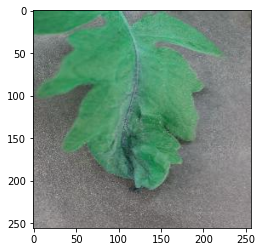

In [7]:
plt.figure()
image = cv2.imread(train_df['image'][0])
plt.imshow(image)

In [8]:
# data augmentation (train)

train_gen = ImageDataGenerator(rescale=1./255,
                               rotation_range=10,
                               zoom_range = 0.1,
                               shear_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True)

train_set = train_gen.flow_from_dataframe(dataframe=train_df,
                                          x_col='image',
                                          y_col='label',
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size,
                                          shuffle=True,
                                          class_mode='categorical',
                                          color_mode='grayscale')

# rescaling (validation)
val_rescaled = ImageDataGenerator(rescale = 1./255)

val_set = val_rescaled.flow_from_dataframe(dataframe=val_df,
                                           x_col='image',
                                           y_col='label',
                                           target_size=(image_size, image_size),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           class_mode='categorical',
                                           color_mode='grayscale')

# rescaling (test)
test_rescaled = ImageDataGenerator(rescale = 1./255)

test_set = test_rescaled.flow_from_dataframe(dataframe=test_df,
                                             x_col='image',
                                             y_col='label',
                                             target_size=(image_size, image_size),
                                             batch_size=1,
                                             shuffle=False,
                                             class_mode='categorical',
                                             color_mode='grayscale')

Found 45562 validated image filenames belonging to 17 classes.
Found 8049 validated image filenames belonging to 17 classes.
Found 9469 validated image filenames belonging to 17 classes.


In [10]:
# build the model

#pretrained_model = MobileNet(input_shape=(image_size, image_size, 3),
#                          include_top=False,
#                          weights='imagenet')

model = Sequential([
    Conv2D(filters = 32, kernel_size = (5,5), padding = 'same', 
           activation ='relu', input_shape = (image_size, image_size, 1)),
    AveragePooling2D(pool_size=(2,2)),
    
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation ='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation ='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation ='relu'),
    AveragePooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.4),
    Dense(len(lable_list), activation='softmax')
])

# model.layers[0].trainable = False

In [11]:
# model configuration
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   patience=8, 
                   restore_best_weights=True)

# lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
#                                  patience = 4, 
#                                  verbose=1,
#                                  factor=0.5, 
#                                  min_lr=0.00005)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 32)      832       
_________________________________________________________________
average_pooling2d_4 (Average (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
average_pooling2d_5 (Average (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
average_pooling2d_6 (Average (None, 32, 32, 128)      

In [12]:
history = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[es]) 

Epoch 1/25
1424/1424 [==============================] - 700s 489ms/step - loss: 1.8237 - accuracy: 0.3989 - val_loss: 0.7479 - val_accuracy: 0.7366
Epoch 2/25
1424/1424 [==============================] - 358s 252ms/step - loss: 0.7821 - accuracy: 0.7275 - val_loss: 0.4217 - val_accuracy: 0.8431
Epoch 3/25
1424/1424 [==============================] - 366s 257ms/step - loss: 0.4907 - accuracy: 0.8253 - val_loss: 0.2626 - val_accuracy: 0.9051
Epoch 4/25
1424/1424 [==============================] - 336s 236ms/step - loss: 0.3835 - accuracy: 0.8602 - val_loss: 0.2463 - val_accuracy: 0.9110
Epoch 5/25
1424/1424 [==============================] - 312s 219ms/step - loss: 0.3416 - accuracy: 0.8744 - val_loss: 0.3190 - val_accuracy: 0.8873
Epoch 6/25
1424/1424 [==============================] - 312s 219ms/step - loss: 0.3126 - accuracy: 0.8879 - val_loss: 0.1744 - val_accuracy: 0.9369
Epoch 7/25
1424/1424 [==============================] - 312s 219ms/step - loss: 0.2795 - accuracy: 0.9005 - val_

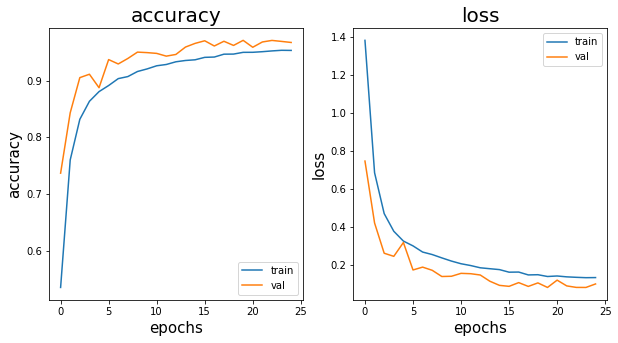

In [13]:
# plot the accuracy and loss of the model
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, e in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[e])
    ax[i].plot(history.history['val_' + e])
    ax[i].set_title(e, fontsize=20)
    ax[i].set_xlabel('epochs', fontsize=15)
    ax[i].set_ylabel(e, fontsize=15)
    ax[i].legend(['train', 'val'])

0 : Tomato___Late_blight
1 : Tomato___healthy
2 : Grape___healthy
3 : Potato___healthy
4 : Corn_(maize)___Northern_Leaf_Blight
5 : Tomato___Early_blight
6 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
7 : Tomato___Bacterial_spot
8 : Pepper,_bell___healthy
9 : Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
10 : Potato___Late_blight
11 : Grape___Black_rot
12 : Potato___Early_blight
13 : Corn_(maize)___Common_rust_
14 : Grape___Esca_(Black_Measles)
15 : Pepper,_bell___Bacterial_spot
16 : Corn_(maize)___healthy


(<Figure size 1440x1440 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

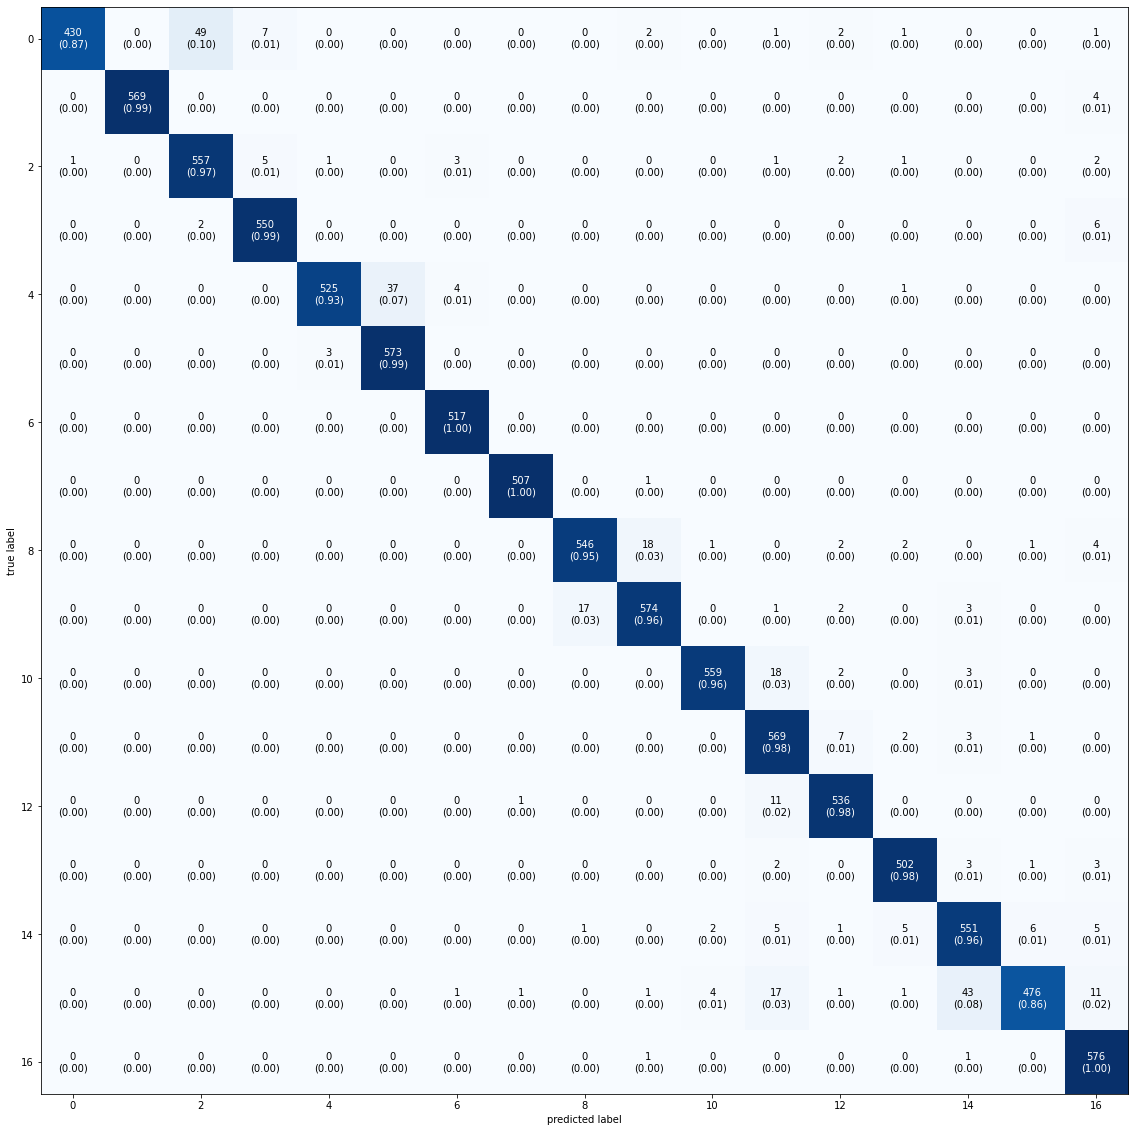

In [14]:
# test the model

for i in range(len(lable_list)):
  print(f"{i} : {lable_list[i]}")

predictions = model.predict_classes(test_set)

cm = confusion_matrix(test_set.classes, predictions)
plot_confusion_matrix(conf_mat = cm, 
                      figsize=(20,20),
                      show_normed=True)

In [15]:
# Ealuate the model

model.evaluate(test_set)

9469/9469 [==============================] - 36s 4ms/step - loss: 0.1108 - accuracy: 0.9628


[0.11083943396806717, 0.9628260731697083]

In [16]:
# test the accuracy of the trained model

test_accuracy = 0

for i in range(len(lable_list)):
    test_accuracy = test_accuracy + cm[i, i]
    
test_accuracy = test_accuracy / len(test_set)
    
print("Test Accuracy: {}%".format(round(test_accuracy * 100, 3)))

Test Accuracy: 96.283%


In [17]:
# save the model for later use

model.save("./modelfinal.h5")
model.save_weights("./weightsfinal.hdf5")

In [18]:
# Load the model

from tensorflow import keras
model2 = keras.models.load_model("./modelfinal.h5")

In [67]:
# predict the external data and store the result

from keras.preprocessing import image

external_path = '/kaggle/input/classification-leaf/External_class'

#external_path = '/kaggle/input/testgrapehealth'

external_set = glob.glob(external_path + '/*')

In [68]:
external = add_labels(external_set, 'test')
print(external[0])

ext_df = pd.DataFrame(external, columns=['image', 'label'])
print('Size of external set: ',len(ext_df))

ext_rescaled = ImageDataGenerator(rescale = 1./255)
ext_set = ext_rescaled.flow_from_dataframe(dataframe=ext_df,
                                             x_col='image',
                                             y_col='label',
                                             target_size=(image_size, image_size),
                                             batch_size=1,
                                             shuffle=False,
                                             class_mode='categorical',
                                             color_mode='grayscale')

('/kaggle/input/classification-leaf/External_class/14 (2).JPG', 'test')
Size of external set:  85
Found 85 validated image filenames belonging to 1 classes.


In [69]:
arr = model2.predict(ext_set)

In [70]:
# print result for testing external data

print(len(arr))

for i in range(len(arr)):
    file = list(arr[i])
    print(f"File {i}: ",file.index(max(file)), " class")

85
File 0:  5  class
File 1:  16  class
File 2:  2  class
File 3:  8  class
File 4:  15  class
File 5:  5  class
File 6:  13  class
File 7:  14  class
File 8:  2  class
File 9:  14  class
File 10:  13  class
File 11:  14  class
File 12:  5  class
File 13:  6  class
File 14:  9  class
File 15:  16  class
File 16:  13  class
File 17:  10  class
File 18:  3  class
File 19:  2  class
File 20:  5  class
File 21:  4  class
File 22:  10  class
File 23:  8  class
File 24:  2  class
File 25:  11  class
File 26:  1  class
File 27:  2  class
File 28:  11  class
File 29:  11  class
File 30:  1  class
File 31:  15  class
File 32:  6  class
File 33:  7  class
File 34:  6  class
File 35:  9  class
File 36:  11  class
File 37:  10  class
File 38:  1  class
File 39:  3  class
File 40:  7  class
File 41:  15  class
File 42:  9  class
File 43:  0  class
File 44:  5  class
File 45:  1  class
File 46:  12  class
File 47:  5  class
File 48:  8  class
File 49:  12  class
File 50:  3  class
File 51:  12  clas